In [1]:
import os
import random
import shutil
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import Model
from tensorflow.keras.utils import img_to_array, load_img
from shutil import copyfile
from PIL import Image
%matplotlib inline

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [2]:
print(tf.__version__)

2.12.0


In [3]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.95 and logs.get('val_accuracy')>=0.94):
      self.model.stop_training = True

callbacks = myCallback()

In [4]:
# Resized gambar agar memiliku jumlah pixel yang sama
def copy_to_working(path, new_path):
    for dirname in os.listdir(path):
      for filename in os.scandir(os.path.join(path, dirname)):
        copyfile(os.path.join(path, dirname, filename.name), os.path.join(new_path, dirname, filename.name))

In [5]:
# Membuat fungsi untuk menyalin data dari sumber data ke train dan test dir seusai yang diinginkan

def split_data(SOURCE_DIR, TRAINING_DIR, VALIDATION_DIR, TESTING_DIR, SPLIT_SIZE):
  all_files = []

  for file_name in os.listdir(SOURCE_DIR):
      file_path = SOURCE_DIR + file_name

      if os.path.getsize(file_path):
          all_files.append(file_name)
      else:
          print('{} is zero length, so ignoring'.format(file_name))

  train_val_size = int(SPLIT_SIZE * len(all_files))
  val_test_size = int(len(all_files) - int((len(all_files)-train_val_size)/2))
  shuffled = random.sample(all_files, len(all_files))
  train, val, test = shuffled[:train_val_size], shuffled[train_val_size:val_test_size], shuffled[val_test_size:]

  for filename in train:
    copyfile(SOURCE_DIR + filename, TRAINING_DIR + filename)

  for filename in val:
    copyfile(SOURCE_DIR + filename, VALIDATION_DIR + filename)

  for filename in test:
    copyfile(SOURCE_DIR + filename, TESTING_DIR + filename)

In [6]:
# Membuat direktori untuk menempatka data yang akan digunakan

root_dir = '/kaggle/working/coffee-leaf-diseases'
tmp_dir = '/kaggle/working/tmp'
source_dir = '/kaggle/input/coffee-disease/Coffee_Disease_Dataset'

if os.path.exists(root_dir):
  shutil.rmtree(root_dir)

if os.path.exists(tmp_dir):
  shutil.rmtree(tmp_dir)

os.mkdir(tmp_dir)
os.mkdir(os.path.join(tmp_dir, 'cerscospora'))
os.mkdir(os.path.join(tmp_dir, 'miner'))
os.mkdir(os.path.join(tmp_dir, 'nodisease'))
os.mkdir(os.path.join(tmp_dir, 'phoma'))
os.mkdir(os.path.join(tmp_dir, 'rust'))

def create_train_test_dirs(root_path):
  os.mkdir(root_path)
  os.mkdir(os.path.join(root_path, 'train'))
  os.mkdir(os.path.join(root_path, 'val'))
  os.mkdir(os.path.join(root_path, 'test'))

  for foldername in os.listdir(os.path.join(source_dir)):
    for i in os.listdir(root_path):
      os.mkdir(os.path.join(root_path, i, foldername))

try:
  create_train_test_dirs(root_path=root_dir)
except FileExistsError:
  print("File Sudah Ada")

In [7]:
# Lokasi Semua Dataset Utama
# Lokasi Dataset Tiap Penyakit
cerscospora_source = os.path.join(source_dir, 'cerscospora/')
healthy_source = os.path.join(source_dir, 'nodisease/')
miner_source = os.path.join(source_dir, 'miner/')
phoma_source = os.path.join(source_dir, 'phoma/')
rust_source = os.path.join(source_dir, 'rust/')

# Lokasi Dataset Tiap Penyakit
cerscospora_tmp = os.path.join(tmp_dir, 'cerscospora/')
healthy_tmp = os.path.join(tmp_dir, 'nodisease/')
miner_tmp = os.path.join(tmp_dir, 'miner/')
phoma_tmp = os.path.join(tmp_dir, 'phoma/')
rust_tmp = os.path.join(tmp_dir, 'rust/')

# Lokasi Utama Dataset Setelah Dibagi
train_dir = os.path.join(root_dir, 'train/')
val_dir = os.path.join(root_dir, 'val/')
test_dir = os.path.join(root_dir, 'test/')

# Lokasi Dataset Training Tiap Penyakit Setelah Di Bagi
train_cerscospora_dir = os.path.join(train_dir, 'cerscospora/')
train_healthty_dir = os.path.join(train_dir, 'nodisease/')
train_miner_dir = os.path.join(train_dir, 'miner/')
train_phoma_dir = os.path.join(train_dir, 'phoma/')
train_rust_dir = os.path.join(train_dir, 'rust/')

# Lokasi Dataset Validation Tiap Penyakit Setelah Di Bagi
val_cerscospora_dir = os.path.join(val_dir, 'cerscospora/')
val_healthty_dir = os.path.join(val_dir, 'nodisease/')
val_miner_dir = os.path.join(val_dir, 'miner/')
val_phoma_dir = os.path.join(val_dir, 'phoma/')
val_rust_dir = os.path.join(val_dir, 'rust/')

# Lokasi Dataset Testing Tiap Penyakit Setelah Di Bagi
test_cerscospora_dir = os.path.join(test_dir, 'cerscospora/')
test_healthty_dir = os.path.join(test_dir, 'nodisease/')
test_miner_dir = os.path.join(test_dir, 'miner/')
test_phoma_dir = os.path.join(test_dir, 'phoma/')
test_rust_dir = os.path.join(test_dir, 'rust/')

In [8]:
# Melihat contoh ukuran dataset
sample_image  = load_img('/kaggle/input/coffee-disease/Coffee_Disease_Dataset/miner/100.jpg')
sample_array = img_to_array(sample_image)
print(f"Each image has shape: {sample_array.shape}")

sample_image  = load_img('/kaggle/input/coffee-disease/Coffee_Disease_Dataset/cerscospora/12088928264_a953dbfae1_b.jpg')
sample_array = img_to_array(sample_image)
print(f"Each image has shape: {sample_array.shape}")

Each image has shape: (1024, 2048, 3)
Each image has shape: (626, 847, 3)


In [9]:
copy_to_working(source_dir, tmp_dir)

In [10]:
# # Jumlah gambar yang ingin tersisa di setiap folder
# jumlah_tersisa = 3000

# for folder in os.listdir(tmp_dir):
#     # Dapatkan daftar semua file gambar dalam folder
#     gambar = [file for file in os.listdir(os.path.join(tmp_dir, folder)) if file.endswith(('.jpg', '.jpeg', '.png', '.gif'))]

#     # Pastikan jumlah gambar yang ingin tersisa tidak melebihi jumlah gambar yang ada
#     jumlah_tersisa = min(jumlah_tersisa, len(gambar))

#     # Jumlah gambar yang akan dihapus
#     jumlah_hapus = len(gambar) - jumlah_tersisa

#     # Acak urutan gambar
#     random.shuffle(gambar)

#     # Hapus gambar secara acak sampai tersisa jumlah tertentu
#     for i in range(jumlah_hapus):
#         file = os.path.join(tmp_dir, folder, gambar[i])
#         os.remove(file)

# print('Penghapusan selesai.')

In [11]:
file_count = len([f for f in os.listdir("/kaggle/working/tmp/rust") if os.path.isfile(os.path.join("/kaggle/working/tmp/rust", f))])
print(f"Jumlah file dalam folder Leaf Rust: {file_count}")
file_count = len([f for f in os.listdir("/kaggle/working/tmp/cerscospora") if os.path.isfile(os.path.join("/kaggle/working/tmp/cerscospora", f))])
print(f"Jumlah file dalam folder Cerscospora: {file_count}")
file_count = len([f for f in os.listdir("/kaggle/working/tmp/miner") if os.path.isfile(os.path.join("/kaggle/working/tmp/miner", f))])
print(f"Jumlah file dalam folder Miner: {file_count}")
file_count = len([f for f in os.listdir("/kaggle/working/tmp/phoma") if os.path.isfile(os.path.join("/kaggle/working/tmp/phoma", f))])
print(f"Jumlah file dalam folder Phoma: {file_count}")
file_count = len([f for f in os.listdir("/kaggle/working/tmp/nodisease") if os.path.isfile(os.path.join("/kaggle/working/tmp/nodisease", f))])
print(f"Jumlah file dalam folder Healthy: {file_count}")

Jumlah file dalam folder Leaf Rust: 340
Jumlah file dalam folder Cerscospora: 335
Jumlah file dalam folder Miner: 492
Jumlah file dalam folder Phoma: 492
Jumlah file dalam folder Healthy: 427


In [12]:
# Pisahkan dan salin data mengguakan fungsi split_data
split_size = .6

split_data(cerscospora_tmp, train_cerscospora_dir, val_cerscospora_dir, test_cerscospora_dir, split_size)
split_data(healthy_tmp, train_healthty_dir, val_healthty_dir, test_healthty_dir, split_size)
split_data(miner_tmp, train_miner_dir, val_miner_dir, test_miner_dir, split_size)
split_data(phoma_tmp, train_phoma_dir, val_phoma_dir, test_phoma_dir, split_size)
split_data(rust_tmp, train_rust_dir, val_rust_dir, test_rust_dir, split_size)

In [13]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Tentukan path folder train dan test
train_dir = '/kaggle/working/coffee-leaf-diseases/train'
val_dir = '/kaggle/working/coffee-leaf-diseases/val'
test_dir = '/kaggle/working/coffee-leaf-diseases/test'

# Load dataset train menjadi array numpy
train_images = []
train_labels = []
val_images = []
val_labels = []
test_images = []
test_labels = []
classes = ['cerscospora', 'nodisease', 'miner', 'phoma', 'rust']
for class_index, class_name in enumerate(classes):
    class_dir = os.path.join(train_dir, class_name)
    for image_name in os.listdir(class_dir):
        image_path = os.path.join(class_dir, image_name)
        img = Image.open(image_path).convert('RGB')
        img = img.resize((300, 150), Image.Resampling.LANCZOS)
        inp_numpy = np.array(img)[None]
        image_array = tf.constant(inp_numpy, dtype='float32')
        train_images.append(image_array)
        train_labels.append(class_index)
    class_dir = os.path.join(val_dir, class_name)
    for image_name in os.listdir(class_dir):
        image_path = os.path.join(class_dir, image_name)
        img = Image.open(image_path).convert('RGB')
        img = img.resize((300, 150), Image.Resampling.LANCZOS)
        inp_numpy = np.array(img)[None]
        image_array = tf.constant(inp_numpy, dtype='float32')
        val_images.append(image_array)
        val_labels.append(class_index)
    class_dir = os.path.join(test_dir, class_name)
    for image_name in os.listdir(class_dir):
        image_path = os.path.join(class_dir, image_name)
        img = Image.open(image_path).convert('RGB')
        img = img.resize((300, 150), Image.Resampling.LANCZOS)
        inp_numpy = np.array(img)[None]
        image_array = tf.constant(inp_numpy, dtype='float32')
        test_images.append(image_array)
        test_labels.append(class_index)

train_images = np.array(train_images)
train_labels = np.array(train_labels)
val_images = np.array(val_images)
val_labels = np.array(val_labels)
test_images = np.array(test_images)
test_labels = np.array(test_labels)

# Konversi dataset train menjadi tf.constant
train_images = tf.constant(np.squeeze(train_images), dtype=tf.float32)
train_labels = tf.constant(train_labels, dtype=tf.int32)
val_images = tf.constant(np.squeeze(val_images), dtype=tf.float32)
val_labels = tf.constant(val_labels, dtype=tf.int32)
test_images = tf.constant(np.squeeze(test_images), dtype=tf.float32)
test_labels = tf.constant(test_labels, dtype=tf.int32)

In [14]:
# Buat model untuk melatih data
MobileNet = MobileNetV2(
        include_top=False,
        weights='imagenet',
        input_shape=(150, 300, 3),
)

for layer in MobileNet.layers:
    layer.trainable = False

x = tf.keras.layers.Flatten()(MobileNet.output)
x = tf.keras.layers.Dense(5, activation='softmax')(x)

model = Model(MobileNet.input, x)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

9406464/9406464 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 300, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 75, 150, 32)  864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 75, 150, 32)  128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)             

# Model with Learning Rate 1e-4

In [15]:
history = model.fit(train_images,
                    train_labels,
                    epochs=25,
                    verbose=1,
                    validation_data=(val_images, val_labels)
                   )

Epoch 1/25
40/40 [==============================] - 14s 90ms/step - loss: 1.1519 - accuracy: 0.5955 - val_loss: 1.0346 - val_accuracy: 0.6444
Epoch 2/25
40/40 [==============================] - 2s 54ms/step - loss: 0.5542 - accuracy: 0.7906 - val_loss: 0.7188 - val_accuracy: 0.7208
Epoch 3/25
40/40 [==============================] - 2s 54ms/step - loss: 0.2911 - accuracy: 0.8977 - val_loss: 0.6447 - val_accuracy: 0.7804
Epoch 4/25
40/40 [==============================] - 2s 61ms/step - loss: 0.2129 - accuracy: 0.9345 - val_loss: 0.6989 - val_accuracy: 0.7303
Epoch 5/25
40/40 [==============================] - 2s 54ms/step - loss: 0.1851 - accuracy: 0.9424 - val_loss: 0.6733 - val_accuracy: 0.7542
Epoch 6/25
40/40 [==============================] - 2s 58ms/step - loss: 0.1028 - accuracy: 0.9872 - val_loss: 0.6102 - val_accuracy: 0.7733
Epoch 7/25
40/40 [==============================] - 2s 54ms/step - loss: 0.0773 - accuracy: 0.9944 - val_loss: 0.6140 - val_accuracy: 0.7924
Epoch 8/25
4

In [16]:
model.evaluate(test_images, test_labels)

13/13 [==============================] - 1s 44ms/step - loss: 0.5854 - accuracy: 0.7861


[0.5854135155677795, 0.786057710647583]

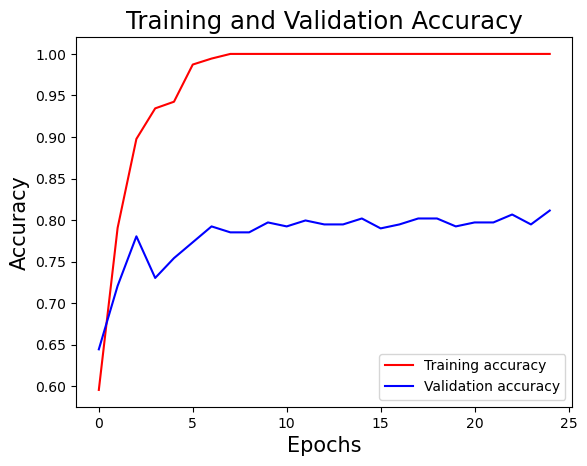

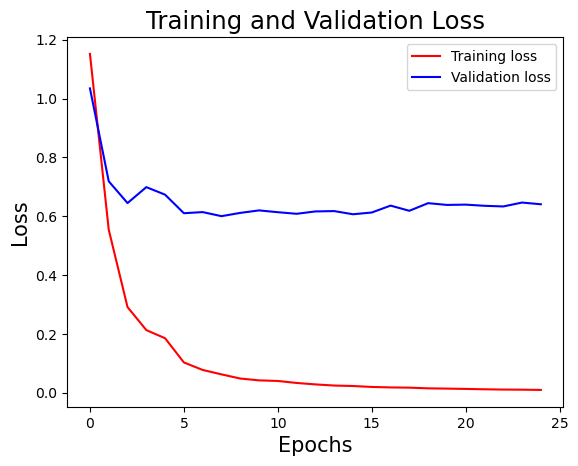

13/13 [==============================] - 1s 36ms/step


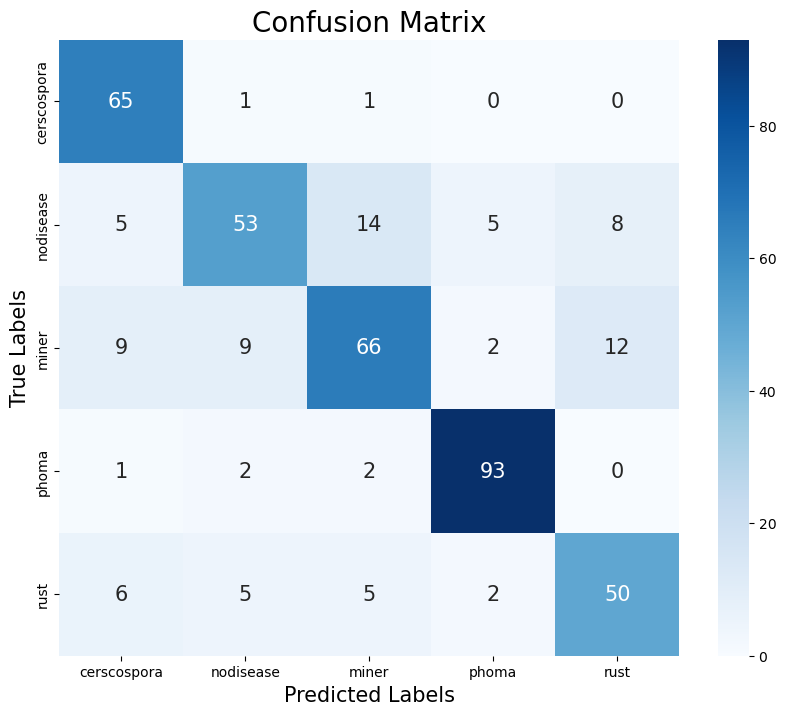

In [17]:
# Plot the training and validation accuracies for each epoch

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

#Train and Validation Accuracy
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and Validation Accuracy', size=17.5)
plt.legend(loc=0)
plt.xlabel("Epochs", size=15)
plt.ylabel("Accuracy", size=15)
plt.savefig('Accuracy_lr_1e-4.png')
plt.show()

#Train and Validation Loss
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss', size=17.5)
plt.legend(loc=0)
plt.xlabel("Epochs", size=15)
plt.ylabel("Loss", size=15)
plt.savefig('Loss_lr_1e-4.png')
plt.show()

# Confusion Matrix Heatmap
# class_labels = sorted(os.listdir('/kaggle/input/coffee-leaf-diseases/train'))
predictions = model.predict(test_images)
predicted_labels = np.argmax(predictions, axis=1)
# true_labels = val_generator.classes
cm = confusion_matrix(test_labels, predicted_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=classes, yticklabels=classes, annot_kws={'size': 15})
plt.xlabel('Predicted Labels', size=15)
plt.ylabel('True Labels', size=15)
plt.title('Confusion Matrix', size=20)
plt.savefig('Confusion Matrix_lr_1e-4.png')
plt.show()

In [18]:
import pandas as pd
pd.DataFrame({
    'acc': acc,
    'val_acc': val_acc,
    'loss': loss,
    'val_loss': val_loss,
})

,acc,val_acc,loss,val_loss
0,0.595524,0.644391,1.151852,1.034608
1,0.790568,0.720764,0.554185,0.718834
2,0.897682,0.780430,0.291105,0.644749
3,0.934452,0.730310,0.212873,0.698913
4,0.942446,0.754177,0.185130,0.673272
5,0.987210,0.773270,0.102811,0.610238
6,0.994404,0.792363,0.077329,0.614048
7,1.000000,0.785203,0.062300,0.600221
8,1.000000,0.785203,0.048128,0.611293
9,1.000000,0.797136,0.041910,0.619826


In [19]:
prediksi = model.predict(test_images)
y_pred = np.argmax(prediksi, axis=1)
# y_true = val_generator.labels

print(classification_report(test_labels, y_pred))

13/13 [==============================] - 0s 36ms/step
              precision    recall  f1-score   support

           0       0.76      0.97      0.85        67
           1       0.76      0.62      0.68        85
           2       0.75      0.67      0.71        98
           3       0.91      0.95      0.93        98
           4       0.71      0.74      0.72        68

    accuracy                           0.79       416
   macro avg       0.78      0.79      0.78       416
weighted avg       0.78      0.79      0.78       416



In [20]:
# Save model dengan format Protobuf
tf.saved_model.save(model, "/kaggle/working/Model")
my_model = tf.saved_model.load('/kaggle/working/Model')

# convert model ke TFLite format
converter = tf.lite.TFLiteConverter.from_keras_model(my_model)
tflite_model = converter.convert()

# save TFLite model
with open('Coffee_disease_MobileNetV2_lr_1e-4.tflite', 'wb') as f:
  f.write(tflite_model)

# Model with Learning Rate 5e-4

In [21]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [22]:
history = model.fit(train_images,
                    train_labels,
                    epochs=25,
                    verbose=1,
                    validation_data=(val_images, val_labels)
                   )

Epoch 1/25
40/40 [==============================] - 6s 81ms/step - loss: 0.8050 - accuracy: 0.8321 - val_loss: 1.1777 - val_accuracy: 0.7279
Epoch 2/25
40/40 [==============================] - 2s 54ms/step - loss: 0.1674 - accuracy: 0.9456 - val_loss: 1.2830 - val_accuracy: 0.7279
Epoch 3/25
40/40 [==============================] - 2s 55ms/step - loss: 0.1086 - accuracy: 0.9640 - val_loss: 1.2773 - val_accuracy: 0.7279
Epoch 4/25
40/40 [==============================] - 2s 57ms/step - loss: 0.0262 - accuracy: 0.9896 - val_loss: 1.2326 - val_accuracy: 0.7804
Epoch 5/25
40/40 [==============================] - 2s 57ms/step - loss: 0.0198 - accuracy: 0.9936 - val_loss: 0.9592 - val_accuracy: 0.7828
Epoch 6/25
40/40 [==============================] - 2s 59ms/step - loss: 0.0020 - accuracy: 1.0000 - val_loss: 0.9068 - val_accuracy: 0.7876
Epoch 7/25
40/40 [==============================] - 2s 54ms/step - loss: 8.7691e-04 - accuracy: 1.0000 - val_loss: 0.9018 - val_accuracy: 0.7852
Epoch 8/2

In [23]:
model.evaluate(test_images, test_labels)

13/13 [==============================] - 1s 43ms/step - loss: 0.7709 - accuracy: 0.7812


[0.7708613276481628, 0.78125]

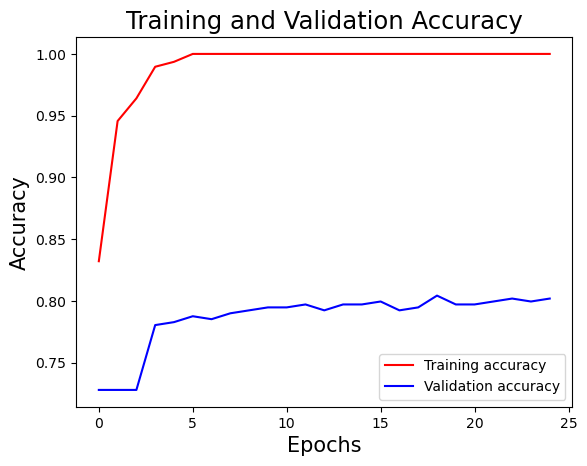

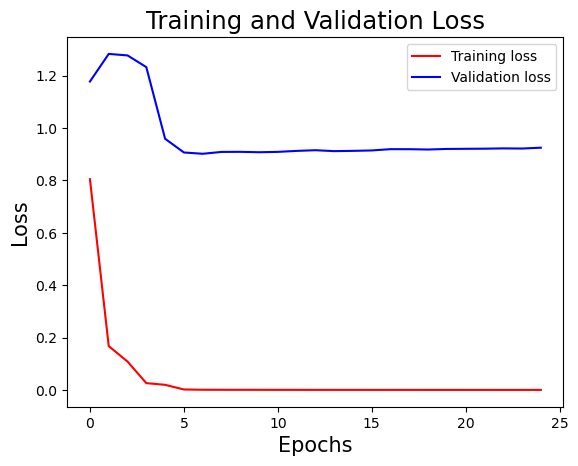

13/13 [==============================] - 1s 37ms/step


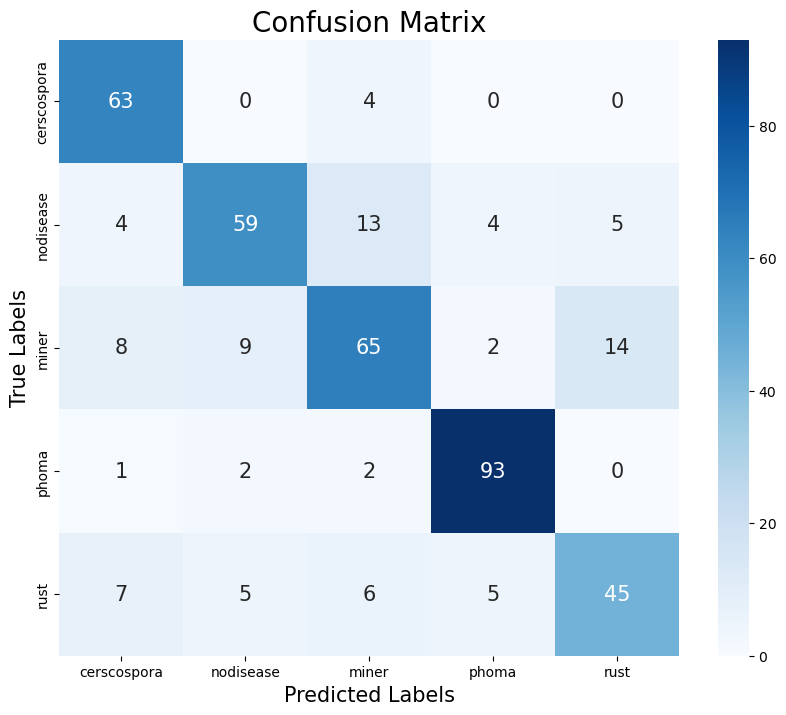

In [24]:
# Plot the training and validation accuracies for each epoch

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

#Train and Validation Accuracy
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and Validation Accuracy', size=17.5)
plt.legend(loc=0)
plt.xlabel("Epochs", size=15)
plt.ylabel("Accuracy", size=15)
plt.savefig('Accuracy_lr_5e-4.png')
plt.show()

#Train and Validation Loss
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss', size=17.5)
plt.legend(loc=0)
plt.xlabel("Epochs", size=15)
plt.ylabel("Loss", size=15)
plt.savefig('Loss_lr_5e-4.png')
plt.show()

# Confusion Matrix Heatmap
# class_labels = sorted(os.listdir('/kaggle/input/coffee-leaf-diseases/train'))
predictions = model.predict(test_images)
predicted_labels = np.argmax(predictions, axis=1)
# true_labels = val_generator.classes
cm = confusion_matrix(test_labels, predicted_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=classes, yticklabels=classes, annot_kws={'size': 15})
plt.xlabel('Predicted Labels', size=15)
plt.ylabel('True Labels', size=15)
plt.title('Confusion Matrix', size=20)
plt.savefig('Confusion Matrix_lr_5e-4.png')
plt.show()

In [25]:
import pandas as pd
pd.DataFrame({
    'acc': acc,
    'val_acc': val_acc,
    'loss': loss,
    'val_loss': val_loss,
})

,acc,val_acc,loss,val_loss
0,0.832134,0.727924,0.805005,1.177672
1,0.945643,0.727924,0.167435,1.283016
2,0.964029,0.727924,0.108578,1.277318
3,0.989608,0.780430,0.026214,1.232594
4,0.993605,0.782816,0.019773,0.959181
5,1.000000,0.787589,0.001958,0.906775
6,1.000000,0.785203,0.000877,0.901804
7,1.000000,0.789976,0.000734,0.908844
8,1.000000,0.792363,0.000652,0.909211
9,1.000000,0.794749,0.000616,0.907678


In [26]:
prediksi = model.predict(test_images)
y_pred = np.argmax(prediksi, axis=1)
# y_true = val_generator.labels

print(classification_report(test_labels, y_pred))

13/13 [==============================] - 0s 37ms/step
              precision    recall  f1-score   support

           0       0.76      0.94      0.84        67
           1       0.79      0.69      0.74        85
           2       0.72      0.66      0.69        98
           3       0.89      0.95      0.92        98
           4       0.70      0.66      0.68        68

    accuracy                           0.78       416
   macro avg       0.77      0.78      0.77       416
weighted avg       0.78      0.78      0.78       416



In [27]:
# Save model dengan format Protobuf
tf.saved_model.save(model, "/kaggle/working/Model")
my_model = tf.saved_model.load('/kaggle/working/Model')

# convert model ke TFLite format
converter = tf.lite.TFLiteConverter.from_keras_model(my_model)
tflite_model = converter.convert()

# save TFLite model
with open('Coffee_disease_MobileNetV2_lr_5e-4.tflite', 'wb') as f:
  f.write(tflite_model)

# Model with Learning Rate 1e-3

In [28]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [29]:
history = model.fit(train_images,
                    train_labels,
                    epochs=25,
                    verbose=1,
                    validation_data=(val_images, val_labels)
                   )

Epoch 1/25
40/40 [==============================] - 6s 81ms/step - loss: 1.5514 - accuracy: 0.8385 - val_loss: 2.4827 - val_accuracy: 0.7613
Epoch 2/25
40/40 [==============================] - 2s 54ms/step - loss: 0.2243 - accuracy: 0.9528 - val_loss: 2.2659 - val_accuracy: 0.7542
Epoch 3/25
40/40 [==============================] - 2s 55ms/step - loss: 0.4562 - accuracy: 0.9273 - val_loss: 2.5592 - val_accuracy: 0.7566
Epoch 4/25
40/40 [==============================] - 2s 57ms/step - loss: 0.2187 - accuracy: 0.9528 - val_loss: 4.6415 - val_accuracy: 0.6850
Epoch 5/25
40/40 [==============================] - 2s 57ms/step - loss: 0.6601 - accuracy: 0.9305 - val_loss: 2.2706 - val_accuracy: 0.7494
Epoch 6/25
40/40 [==============================] - 2s 57ms/step - loss: 0.1342 - accuracy: 0.9688 - val_loss: 3.5272 - val_accuracy: 0.7232
Epoch 7/25
40/40 [==============================] - 2s 54ms/step - loss: 0.1598 - accuracy: 0.9632 - val_loss: 2.2824 - val_accuracy: 0.7780
Epoch 8/25
40

In [30]:
model.evaluate(test_images, test_labels)

13/13 [==============================] - 1s 43ms/step - loss: 2.3250 - accuracy: 0.7740


[2.325040340423584, 0.7740384340286255]

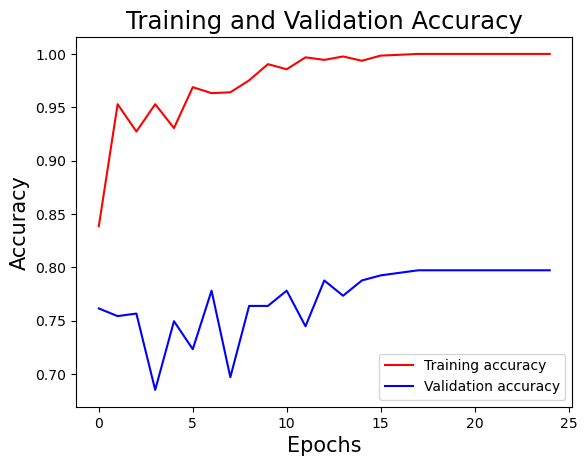

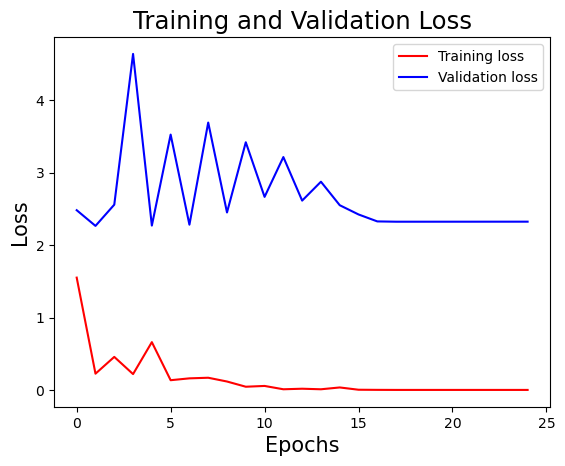

13/13 [==============================] - 1s 37ms/step


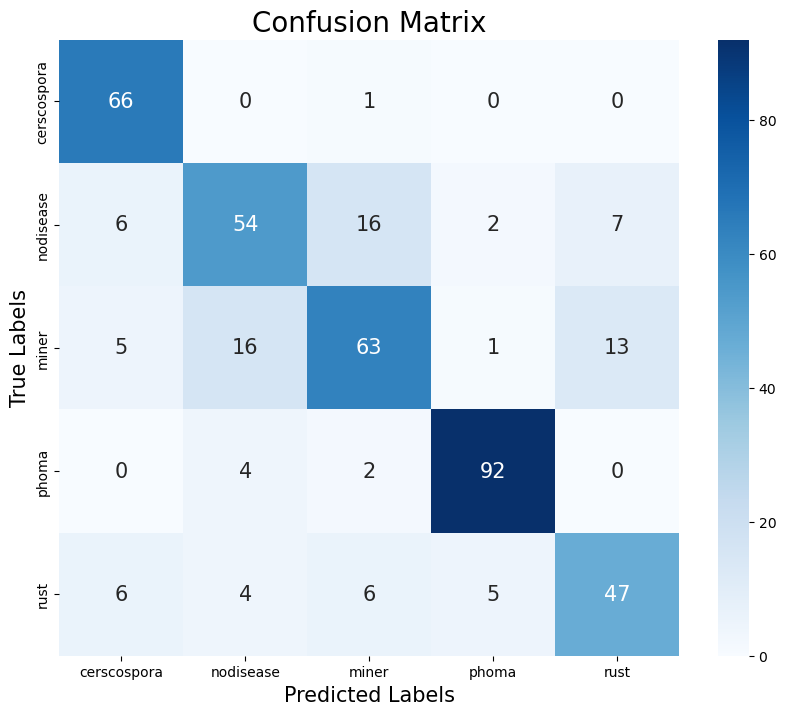

In [31]:
# Plot the training and validation accuracies for each epoch

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

#Train and Validation Accuracy
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and Validation Accuracy', size=17.5)
plt.legend(loc=0)
plt.xlabel("Epochs", size=15)
plt.ylabel("Accuracy", size=15)
plt.savefig('Accuracy_lr_1e-3.png')
plt.show()

#Train and Validation Loss
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss', size=17.5)
plt.legend(loc=0)
plt.xlabel("Epochs", size=15)
plt.ylabel("Loss", size=15)
plt.savefig('Loss_lr_1e-3.png')
plt.show()

# Confusion Matrix Heatmap
# class_labels = sorted(os.listdir('/kaggle/input/coffee-leaf-diseases/train'))
predictions = model.predict(test_images)
predicted_labels = np.argmax(predictions, axis=1)
# true_labels = val_generator.classes
cm = confusion_matrix(test_labels, predicted_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=classes, yticklabels=classes, annot_kws={'size': 15})
plt.xlabel('Predicted Labels', size=15)
plt.ylabel('True Labels', size=15)
plt.title('Confusion Matrix', size=20)
plt.savefig('Confusion Matrix_lr_1e-3.png')
plt.show()

In [32]:
import pandas as pd
pd.DataFrame({
    'acc': acc,
    'val_acc': val_acc,
    'loss': loss,
    'val_loss': val_loss,
})

,acc,val_acc,loss,val_loss
0,0.838529,0.761337,1.551407,2.482742
1,0.952838,0.754177,0.224294,2.265887
2,0.927258,0.756563,0.456185,2.559161
3,0.952838,0.684964,0.218711,4.641508
4,0.930456,0.749403,0.660129,2.270576
5,0.968825,0.723150,0.134235,3.527210
6,0.963229,0.778043,0.159838,2.282401
7,0.964029,0.696897,0.168242,3.693515
8,0.975220,0.763723,0.116132,2.451416
9,0.990408,0.763723,0.044136,3.421096


In [33]:
prediksi = model.predict(test_images)
y_pred = np.argmax(prediksi, axis=1)
# y_true = val_generator.labels

print(classification_report(test_labels, y_pred))

13/13 [==============================] - 0s 37ms/step
              precision    recall  f1-score   support

           0       0.80      0.99      0.88        67
           1       0.69      0.64      0.66        85
           2       0.72      0.64      0.68        98
           3       0.92      0.94      0.93        98
           4       0.70      0.69      0.70        68

    accuracy                           0.77       416
   macro avg       0.76      0.78      0.77       416
weighted avg       0.77      0.77      0.77       416



In [34]:
# Save model dengan format Protobuf
tf.saved_model.save(model, "/kaggle/working/Model")
my_model = tf.saved_model.load('/kaggle/working/Model')

# convert model ke TFLite format
converter = tf.lite.TFLiteConverter.from_keras_model(my_model)
tflite_model = converter.convert()

# save TFLite model
with open('Coffee_disease_MobileNetV2_lr_1e-3.tflite', 'wb') as f:
  f.write(tflite_model)

In [35]:
print("Train")
print("Cerscospora:", len(os.listdir("/kaggle/working/coffee-leaf-diseases/train/cerscospora")))
print("No Disease:", len(os.listdir("/kaggle/working/coffee-leaf-diseases/train/nodisease")))
print("Miner:", len(os.listdir("/kaggle/working/coffee-leaf-diseases/train/miner")))
print("Phoma:", len(os.listdir("/kaggle/working/coffee-leaf-diseases/train/phoma")))
print("Rust:", len(os.listdir("/kaggle/working/coffee-leaf-diseases/train/rust")))

print("\nVal")
print("Cerscospora:", len(os.listdir("/kaggle/working/coffee-leaf-diseases/val/cerscospora")))
print("No Disease:", len(os.listdir("/kaggle/working/coffee-leaf-diseases/val/nodisease")))
print("Miner:", len(os.listdir("/kaggle/working/coffee-leaf-diseases/val/miner")))
print("Phoma:", len(os.listdir("/kaggle/working/coffee-leaf-diseases/val/phoma")))
print("Rust:", len(os.listdir("/kaggle/working/coffee-leaf-diseases/val/rust")))

print("\nTest")
print("Cerscospora:", len(os.listdir("/kaggle/working/coffee-leaf-diseases/test/cerscospora")))
print("No Disease:", len(os.listdir("/kaggle/working/coffee-leaf-diseases/test/nodisease")))
print("Miner:", len(os.listdir("/kaggle/working/coffee-leaf-diseases/test/miner")))
print("Phoma:", len(os.listdir("/kaggle/working/coffee-leaf-diseases/test/phoma")))
print("Rust:", len(os.listdir("/kaggle/working/coffee-leaf-diseases/test/rust")))

Train
Cerscospora: 201
No Disease: 256
Miner: 295
Phoma: 295
Rust: 204

Val
Cerscospora: 67
No Disease: 86
Miner: 99
Phoma: 99
Rust: 68

Test
Cerscospora: 67
No Disease: 85
Miner: 98
Phoma: 98
Rust: 68
